In [216]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

In [217]:
#Defining global constants
batch_size = 32

In [218]:
#Fixating seed to achieve reproducible results
np.random.seed(111)
torch.manual_seed(111)
torch.cuda.manual_seed(111)

In [219]:
#Importing train and test datasets
df_train = pd.read_csv(
    "https://media.githubusercontent.com/media/psi3471/datasets/main/disease_prediction/disease_train.csv"
).drop(columns=["Unnamed: 0"])

df_test = pd.read_csv(
    "https://media.githubusercontent.com/media/psi3471/datasets/main/disease_prediction/disease_test.csv"
).drop(columns=["Unnamed: 0"])

#Separating features and targets
X_train = df_train.iloc[:, 0:8].values
y_train = df_train.iloc[:, 8].values

X_test = df_test.iloc[:, 0:8].values
y_test = df_test.iloc[:, 8].values

In [220]:
#Defining a dataset class to handle the data
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

In [221]:
#Instantiating training and testing datasets
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

In [222]:
#Creating data loaders for the torch model
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) 

In [223]:
#Defining the model
import torch.nn as nn

# Define the neural network
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        # Linear layer with 8 inputs and 1 output (1 neuron)
        self.fc = nn.Linear(8, 1)

    def forward(self, x):
        x = self.fc(x)
        return x

# Create an instance of the network
simple_model = MyNet()

# Move the model to GPU if available
if torch.cuda.is_available():
    simple_model = simple_model.cuda()


In [224]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(simple_model.parameters(), lr=0.001)

#Defining a learning rate scheduller:
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# List to store loss values for each epoch
train_losses = []
valid_losses = []

# Number of epochs
n_epochs = 100  # you can adjust this value

In [225]:
# Initialize the early_stopping counter
no_improvement = 0
no_improvement_threshold = 5  # you can adjust this value
best_valid_loss = float('inf') 

# Training loop
for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training phase
    simple_model.train()
    for data, target in train_loader:
        # If GPU is available, move data and target to GPU
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = simple_model(data.float())
        loss = criterion(output, target.view(-1, 1).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    # Validation phase
    simple_model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                
            output = simple_model(data.float())
            loss = criterion(output, target.view(-1, 1).float())
            valid_loss += loss.item() * data.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(test_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    #Implementing early stopping to prevent overfitting
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(simple_model.state_dict(), 'best_model.pt')  # save the best model
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement == no_improvement_threshold:
            print("No improvement in validation loss for {} epochs. Stopping training.".format(no_improvement_threshold))
            break

    #Adapting learning rate
    scheduler.step()

    # Print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, train_loss, valid_loss))

Epoch: 1 	Training Loss: 13.010502 	Validation Loss: 11.462533
Epoch: 2 	Training Loss: 8.361690 	Validation Loss: 6.670661
Epoch: 3 	Training Loss: 4.514993 	Validation Loss: 3.143091
Epoch: 4 	Training Loss: 2.475286 	Validation Loss: 1.956046
Epoch: 5 	Training Loss: 2.011006 	Validation Loss: 1.802771
Epoch: 6 	Training Loss: 1.954221 	Validation Loss: 1.774522
Epoch: 7 	Training Loss: 1.912091 	Validation Loss: 1.732944
Epoch: 8 	Training Loss: 1.869721 	Validation Loss: 1.701080
Epoch: 9 	Training Loss: 1.829744 	Validation Loss: 1.666661
Epoch: 10 	Training Loss: 1.791552 	Validation Loss: 1.639108
Epoch: 11 	Training Loss: 1.765975 	Validation Loss: 1.636702
Epoch: 12 	Training Loss: 1.762038 	Validation Loss: 1.633751
Epoch: 13 	Training Loss: 1.758205 	Validation Loss: 1.629478
Epoch: 14 	Training Loss: 1.754798 	Validation Loss: 1.628448
Epoch: 15 	Training Loss: 1.749920 	Validation Loss: 1.624322
Epoch: 16 	Training Loss: 1.745740 	Validation Loss: 1.619958
Epoch: 17 	Trai

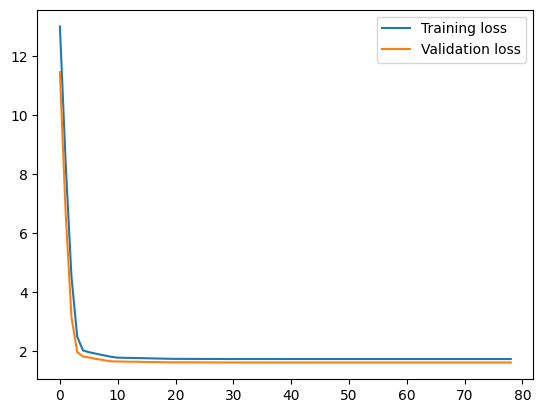

In [226]:
# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.show()

In [227]:
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Load the best model
simple_model.load_state_dict(torch.load('best_model.pt'))

# Set model to evaluation mode
simple_model.eval()

# Make predictions on the test data
predictions = []
targets = []

with torch.no_grad():
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        output = simple_model(data.float())
        pred = torch.round(torch.sigmoid(output))  # round the output to 0 or 1
        predictions.extend(pred.cpu().numpy())
        targets.extend(target.cpu().numpy())

# Compute metrics
conf_mat = confusion_matrix(targets, predictions)
accuracy = accuracy_score(targets, predictions)
f1 = f1_score(targets, predictions)

print("Confusion Matrix:\n", conf_mat)
print("\nAccuracy: ", accuracy)
print("\nF1 Score: ", f1)


Confusion Matrix:
 [[77 28]
 [23 26]]

Accuracy:  0.6688311688311688

F1 Score:  0.5048543689320388


# Develloping a more complex architecture

In [228]:
import torch.nn.functional as F

# Define the neural network
class ComplexModel(nn.Module):
    def __init__(self):
        super(ComplexModel, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # linear output
        return x

# Create an instance of the network
complex_model = ComplexModel()

# Move the model to GPU if available
if torch.cuda.is_available():
    complex_model = complex_model.cuda()

In [229]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(complex_model.parameters(), lr=0.001)

#Defining a learning rate scheduller:
scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# List to store loss values for each epoch
train_losses = []
valid_losses = []

# Number of epochs
n_epochs = 100  # you can adjust this value

In [230]:
# Initialize the early_stopping counter
no_improvement = 0
no_improvement_threshold = 5  # you can adjust this value
best_valid_loss = float('inf') 

# Training loop
for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0
    
    # Training phase
    complex_model.train()
    for data, target in train_loader:
        # If GPU is available, move data and target to GPU
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = complex_model(data.float())
        loss = criterion(output, target.view(-1, 1).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)

    # Validation phase
    complex_model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                
            output = complex_model(data.float())
            loss = criterion(output, target.view(-1, 1).float())
            valid_loss += loss.item() * data.size(0)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(test_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    #Implementing early stopping to prevent overfitting
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(complex_model.state_dict(), 'best_model_complex.pt')  # save the best model
        no_improvement = 0
    else:
        no_improvement += 1
        if no_improvement == no_improvement_threshold:
            print("No improvement in validation loss for {} epochs. Stopping training.".format(no_improvement_threshold))
            break

    #Adapting learning rate
    scheduler.step()

    # Print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, train_loss, valid_loss))

Epoch: 1 	Training Loss: 1.230851 	Validation Loss: 0.696877
Epoch: 2 	Training Loss: 0.749754 	Validation Loss: 0.648342
Epoch: 3 	Training Loss: 0.652335 	Validation Loss: 0.625544
Epoch: 4 	Training Loss: 0.637421 	Validation Loss: 0.630444
Epoch: 5 	Training Loss: 0.641419 	Validation Loss: 0.615838
Epoch: 6 	Training Loss: 0.631742 	Validation Loss: 0.609363
Epoch: 7 	Training Loss: 0.628426 	Validation Loss: 0.602954
Epoch: 8 	Training Loss: 0.614340 	Validation Loss: 0.609997
Epoch: 9 	Training Loss: 0.613903 	Validation Loss: 0.606303
Epoch: 10 	Training Loss: 0.609850 	Validation Loss: 0.596915
Epoch: 11 	Training Loss: 0.604385 	Validation Loss: 0.595606
Epoch: 12 	Training Loss: 0.605186 	Validation Loss: 0.598535
Epoch: 13 	Training Loss: 0.604176 	Validation Loss: 0.597521
Epoch: 14 	Training Loss: 0.603392 	Validation Loss: 0.595167
Epoch: 15 	Training Loss: 0.602844 	Validation Loss: 0.594139
Epoch: 16 	Training Loss: 0.602827 	Validation Loss: 0.594572
Epoch: 17 	Traini

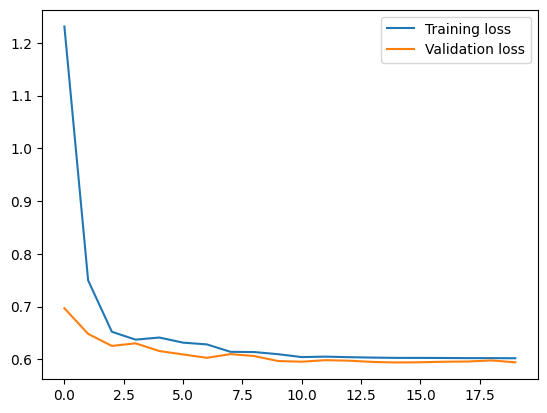

In [231]:
# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend()
plt.show()

In [232]:
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# Load the best model
complex_model.load_state_dict(torch.load('best_model_complex.pt'))

# Set model to evaluation mode
complex_model.eval()

# Make predictions on the test data
predictions = []
targets = []

with torch.no_grad():
    for data, target in test_loader:
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        output = complex_model(data.float())
        pred = torch.round(torch.sigmoid(output))  # round the output to 0 or 1
        predictions.extend(pred.cpu().numpy())
        targets.extend(target.cpu().numpy())

# Compute metrics
conf_mat = confusion_matrix(targets, predictions)
accuracy = accuracy_score(targets, predictions)
f1 = f1_score(targets, predictions)

print("Confusion Matrix:\n", conf_mat)
print("\nAccuracy: ", accuracy)
print("\nF1 Score: ", f1)


Confusion Matrix:
 [[93 12]
 [37 12]]

Accuracy:  0.6818181818181818

F1 Score:  0.3287671232876712
